In [1]:
import random
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

MIN_SIMILARITY_WITH_GT_REGION = 0.5
MIN_SIMILARITY_WITH_NEIGHBOR_BBOX = 0.3

img_name = "3"

tic = time.time()

In [2]:
def getCameraParams ( isColor: bool ) :
    # TODO : consider distortion

    # RGB Intrinsic Parameters
    fx_rgb = 5.1885790117450188e+02
    fy_rgb = 5.1946961112127485e+02
    cx_rgb = 3.2558244941119034e+02
    cy_rgb = 2.5373616633400465e+02
    # # RGB Distortion Parameters
    # k1_rgb =  2.0796615318809061e-01
    # k2_rgb = -5.8613825163911781e-01
    # k3_rgb = 4.9856986684705107e-01
    # p1_rgb = 7.2231363135888329e-04
    # p2_rgb = 1.0479627195765181e-03

    # Depth Intrinsic Parameters
    fx_d = 5.8262448167737955e+02
    fy_d = 5.8269103270988637e+02
    cx_d = 3.1304475870804731e+02
    cy_d = 2.3844389626620386e+02
    # # RGB Distortion Parameters
    # k1_d = -9.9897236553084481e-02
    # k2_d = 3.9065324602765344e-01
    # k3_d = -5.1031725053400578e-01
    # p1_d = 1.9290592870229277e-03
    # p2_d = -1.9422022475975055e-03

    if isColor :
        return cx_rgb, cy_rgb, fx_rgb, fy_rgb
    return cx_d, cy_d, fx_d, fy_d

In [3]:
root_dir = "../nyudv2"
# image = cv2.imread(f"{root_dir}/rgb_{img_name}.png")
# image_depth = np.mean(cv2.imread(f"{root_dir}/depth_{img_name}.png"), axis=2)
# image_labelmaps = cv2.imread(f"{root_dir}/label_maps_{img_name}.png")
image = np.load(f"{root_dir}/rgb/{img_name}.npy")
image_depth = np.load(f"{root_dir}/depth/{img_name}.npy")
image_labelmaps = np.load(f"{root_dir}/label/{img_name}.npy")
image_instmaps = np.load(f"{root_dir}/instance/{img_name}.npy")

image_hha = cv2.imread(f"{root_dir}/hha/{img_name}.png")

In [4]:
print(image.shape)
print(image_depth.shape)
print(image_labelmaps.shape)
print(image_instmaps.shape)
print(image_hha.shape)

(480, 640, 3)
(480, 640)
(480, 640)
(480, 640)
(480, 640, 3)


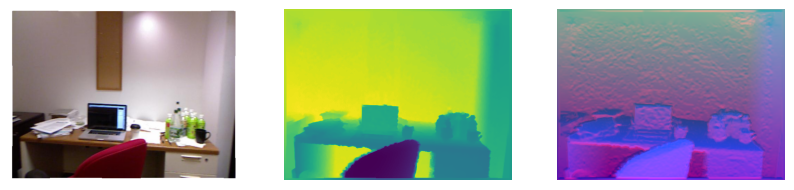

In [5]:
_, subplts = plt.subplots(1, 3, figsize=(10, 10))
subplts[0].imshow(image)
subplts[0].axis('off')
subplts[1].imshow(image_depth)
subplts[1].axis('off')
subplts[2].imshow(image_hha)
subplts[2].axis('off')
plt.show()

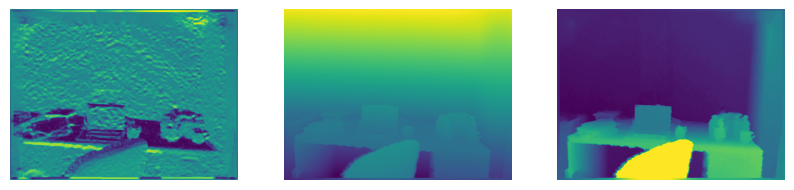

In [6]:
_, subplts = plt.subplots(1, 3, figsize=(10, 10))
subplts[0].imshow(image_hha[:, :, 0])
subplts[0].axis('off')
subplts[1].imshow(image_hha[:, :, 1])
subplts[1].axis('off')
subplts[2].imshow(image_hha[:, :, 2])
subplts[2].axis('off')
plt.show()

In [7]:
image_xyz = np.zeros((image_depth.shape[0], image_depth.shape[1], 3))
height, width = image_depth.shape
CX_DEPTH, CY_DEPTH, FX_DEPTH, FY_DEPTH = getCameraParams(isColor=False)
for i in range(height):
   for j in range(width):
       z = image_depth[i,j]
       x = (j - CX_DEPTH) * z / FX_DEPTH
       y = (i - CY_DEPTH) * z / FY_DEPTH
       image_xyz[i,j] = [x, y, z]

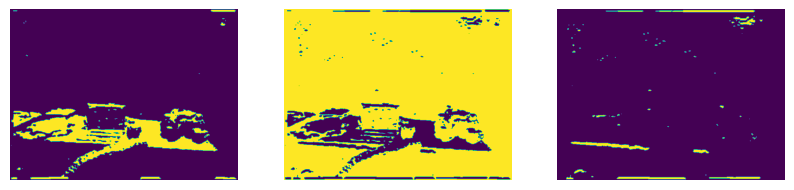

In [8]:
down = image_hha[:, :, 0] < 255/3
horiz = ( 255/3 <= image_hha[:, :, 0] ) & ( image_hha[:, :, 0] < 2*255/3 )
up = 2*255/3 <= image_hha[:, :, 0]

_, subplts = plt.subplots(1, 3, figsize=(10, 10))
subplts[0].imshow(down)
subplts[0].axis('off')
subplts[1].imshow(horiz)
subplts[1].axis('off')
subplts[2].imshow(up)
subplts[2].axis('off')
plt.show()

In [9]:
image_labinsts = np.concatenate((image_labelmaps[:, :, np.newaxis], image_instmaps[:, :, np.newaxis]), axis=-1)
fg_linsts = np.array(list({ (l,i) for l, i in image_labinsts.reshape(-1, 2) if l != 0 and i != 0 })) # 0 is background (boundaries, etc)

allmasks = list()
for label, inst in fg_linsts :
    mask = (image_labinsts[:, :, 0] == label) & (image_labinsts[:, :, 1] == inst)
    allmasks.append((label, inst, mask))

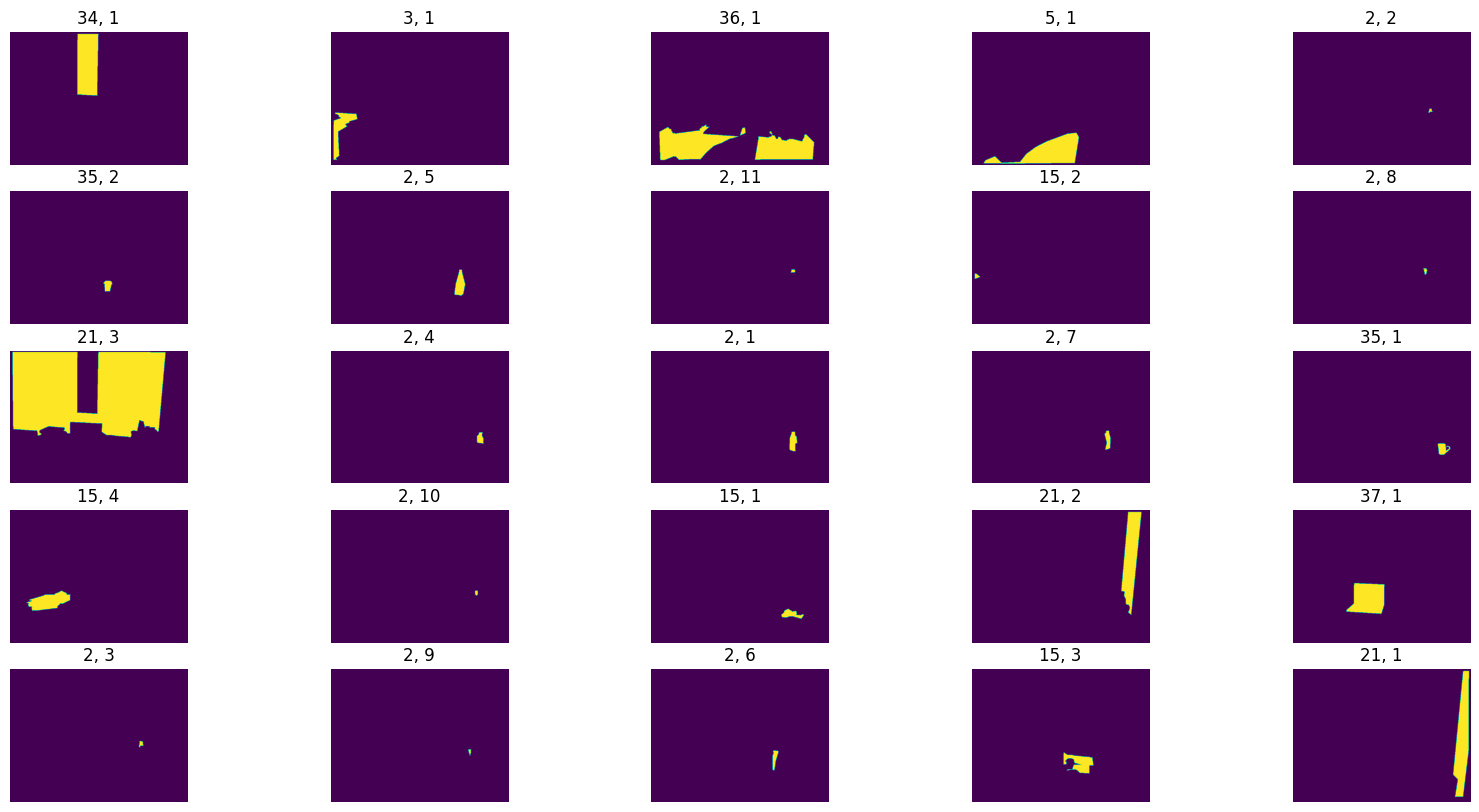

In [10]:
masks_per_row = 5
_, subplts = plt.subplots(int(np.ceil(len(allmasks)/masks_per_row)), masks_per_row, figsize=(20, 10))
for subplt in subplts.flatten() :
    subplt.axis('off')
for idx, (l, i, imask) in enumerate(allmasks) :
    subplts[idx//masks_per_row][idx%masks_per_row].imshow(imask)
    subplts[idx//masks_per_row][idx%masks_per_row].axis('off')
    subplts[idx//masks_per_row][idx%masks_per_row].set_title(f"{l}, {i}")
plt.show()

In [11]:
print("unique label classes:", np.unique(image_labelmaps))
print("number of unique label classes:", len(np.unique(image_labelmaps)))

unique label classes: [ 0  2  3  5 15 21 34 35 36 37]
number of unique label classes: 10


In [12]:
needFast = False

In [13]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.addImage(image_hha)
if needFast :
	print("[INFO] using *fast* selective search")
	ss.switchToSelectiveSearchFast()
else:
	print("[INFO] using *quality* selective search")
	ss.switchToSelectiveSearchQuality()

[INFO] using *quality* selective search


In [14]:
# run selective search on the input image
start = time.time()
rects = ss.process()
end = time.time()
# show how along selective search took to run along with the total
# number of returned region proposals
print("[INFO] selective search took {:.4f} seconds".format(end - start))
print("[INFO] {} total region proposals".format(len(rects)))

[INFO] selective search took 8.7756 seconds
[INFO] 6594 total region proposals


In [15]:
show_initial_bboxes = False
if show_initial_bboxes :
	bocses_per = 30
	for i in range(0, len(rects), bocses_per):
		output = image.copy()
		for (x, y, w, h) in rects[i:i + bocses_per]:
			color = [random.randint(0, 255) for _ in range(0, 3)]
			cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
		cv2.imshow("Output", output)
		key = cv2.waitKey(0) & 0xFF
		if key == ord("q"):
			break
	cv2.destroyWindow("Output")

In [16]:
def ground_truth_region_label ( rect ) :
    best_class, best_score = 0, MIN_SIMILARITY_WITH_GT_REGION
    x, y, w, h = rect
    labels_in_question = np.unique(image_labinsts[y:y+h, x:x+w, 0])
    insts_in_question = np.unique(image_labinsts[y:y+h, x:x+w, 1])
    for label, inst, mask in allmasks :
        if label not in labels_in_question or inst not in insts_in_question :
            continue
        # NOTE : remember that allmasks doesnt contain background mask
        mask_region = mask[y:y+h, x:x+w]
        # using jaccard similarity as per the paper
        sim = np.sum(mask_region) / ( np.sum(mask) + w*h - np.sum(mask_region) )
        if sim > best_score :
            best_score = sim
            best_class = label
    return best_class, best_score

In [17]:
def bb_jaccardsimilarity ( bb1, bb2 ) :
    x1,y1,w1,h1 = bb1
    x2,y2,w2,h2 = bb2
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    w_intersection = min(x1+w1, x2+w2) - x_intersection
    h_intersection = min(y1+h1, y2+h2) - y_intersection

    if w_intersection <= 0 or h_intersection <= 0 :
        return 0.0
    iou = ( w_intersection * h_intersection ) / ( w1*h1 + w2*h2 - w_intersection*h_intersection )
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [18]:
data_unsupressed = list()
for (x, y, w, h) in rects:
    gt_label, gt_score = ground_truth_region_label((x, y, w, h))
    data_unsupressed.append((x, y, w, h, gt_label, gt_score))
data_unsupressed = np.asanyarray(data_unsupressed)
sorting_order = data_unsupressed[:, -1].argsort()[::-1]
data_unsupressed = data_unsupressed[sorting_order]
# NOTE : now the data_unsupressed is sorted by gt_score (descending order)

# supress non maximal boxes
regions_supressed, labels_supressed, scores_supressed = list(), list(), list()
for data in data_unsupressed :
    bb = data[:4]
    for bb_ in regions_supressed :
        if bb_jaccardsimilarity(bb, bb_) > MIN_SIMILARITY_WITH_NEIGHBOR_BBOX :
            break
    else :
        # NOTE : this is not a typo, it is a python feature
        # NOTE : code reaches here only if the above for loop is not exited by break
        regions_supressed.append(bb)
        labels_supressed.append(data[4])
        scores_supressed.append(data[5])
regions_supressed = np.asanyarray(regions_supressed).astype(int)
labels_supressed = np.asanyarray(labels_supressed).astype(int)
scores_supressed = np.asanyarray(scores_supressed)

In [19]:
X_supressed, Y_supressed = list(), list()
for (x, y, w, h), (gt_labels, gt_scores) in zip(regions_supressed, zip(labels_supressed, scores_supressed) ) :
    proposed_box_rgb = image[y:y+h, x:x+w]
    proposed_box_depth = image_depth[y:y+h, x:x+w]
    proposed_box_angle = image_hha[y:y+h, x:x+w][:, :, 0]
    proposed_box_height = image_hha[y:y+h, x:x+w][:, :, 1]
    proposed_box_disparity = image_hha[y:y+h, x:x+w][:, :, 2]
    proposed_box_xyz = image_xyz[y:y+h, x:x+w].reshape(-1, 3)

    depth_mean_sd = np.mean(proposed_box_depth), np.std(proposed_box_depth)
    height_mean_sd = np.mean(proposed_box_height), np.std(proposed_box_height)
    angle_mean_sd = np.mean(proposed_box_angle), np.std(proposed_box_angle)
    disparity_mean_sd = np.mean(proposed_box_disparity), np.std(proposed_box_disparity)
    x_mean_sd = np.mean(proposed_box_xyz[:, 0]), np.std(proposed_box_xyz[:, 0])
    y_mean_sd = np.mean(proposed_box_xyz[:, 1]), np.std(proposed_box_xyz[:, 1])
    z_mean_sd = np.mean(proposed_box_xyz[:, 2]), np.std(proposed_box_xyz[:, 2])
    extent_x = np.max(proposed_box_xyz[:, 0]) - np.min(proposed_box_xyz[:, 0])
    extent_y = np.max(proposed_box_xyz[:, 1]) - np.min(proposed_box_xyz[:, 1])
    extent_z = np.max(proposed_box_xyz[:, 2]) - np.min(proposed_box_xyz[:, 2])
    min_height = np.min(proposed_box_height)
    max_height = np.max(proposed_box_height)
    frac_facing_down = np.sum(proposed_box_angle < 255/3) / (w*h)
    frac_facing_horiz = np.sum(( 255/3 <= proposed_box_angle ) & ( proposed_box_angle < 2*255/3 )) / (w*h)
    frac_facing_up = np.sum(2*255/3 <= proposed_box_angle) / (w*h)

    area = w*h
    perimeter = 2*(w+h)
    location = x / image.shape[1], y / image.shape[0]
    aspect_ratio = w / h
    # perimeter (and sum of contour strength) divided by the squared root of the area
    # area of the region divided by that of the bounding box.
    # Sum of contour strength at the boundaries
    # mean contour strength at the boundaries
    # minimum and maximum UCM threshold of appearance and disappearance of the regions forming the candidate.

    r_mean_sd = np.mean(proposed_box_rgb[:, :, 0]), np.std(proposed_box_rgb[:, :, 0])
    g_mean_sd = np.mean(proposed_box_rgb[:, :, 1]), np.std(proposed_box_rgb[:, :, 1])
    b_mean_sd = np.mean(proposed_box_rgb[:, :, 2]), np.std(proposed_box_rgb[:, :, 2])
    d_mean_sd = np.mean(proposed_box_depth), np.std(proposed_box_depth)

    features = [ gt_score,x,y,w,h, *depth_mean_sd, *height_mean_sd, *angle_mean_sd, *disparity_mean_sd, *x_mean_sd, *y_mean_sd, *z_mean_sd, extent_x, extent_y, extent_z, min_height, max_height, frac_facing_down, frac_facing_horiz, frac_facing_up, area, perimeter, *location, aspect_ratio, *r_mean_sd, *g_mean_sd, *b_mean_sd, *d_mean_sd ]
    # NOTE : remove gt_score,x,y,w,h from features before training
    X_supressed.append(features)
    Y_supressed.append(gt_labels)
X_supressed = np.asanyarray(X_supressed)
Y_supressed = np.asanyarray(Y_supressed)

In [20]:
print("Number of boxes before supression : ", len(data_unsupressed))
print("Number of boxes after supression : ", len(X_supressed))
print()
print(np.asanyarray(np.unique(Y_supressed, return_counts=True)).T)
print("Number of classes excluding background : ", len(np.unique(Y_supressed[Y_supressed!=0])))

Number of boxes before supression :  6594
Number of boxes after supression :  474

[[  0 460]
 [  2   4]
 [  5   1]
 [ 15   3]
 [ 21   2]
 [ 34   1]
 [ 35   1]
 [ 36   1]
 [ 37   1]]
Number of classes excluding background :  8


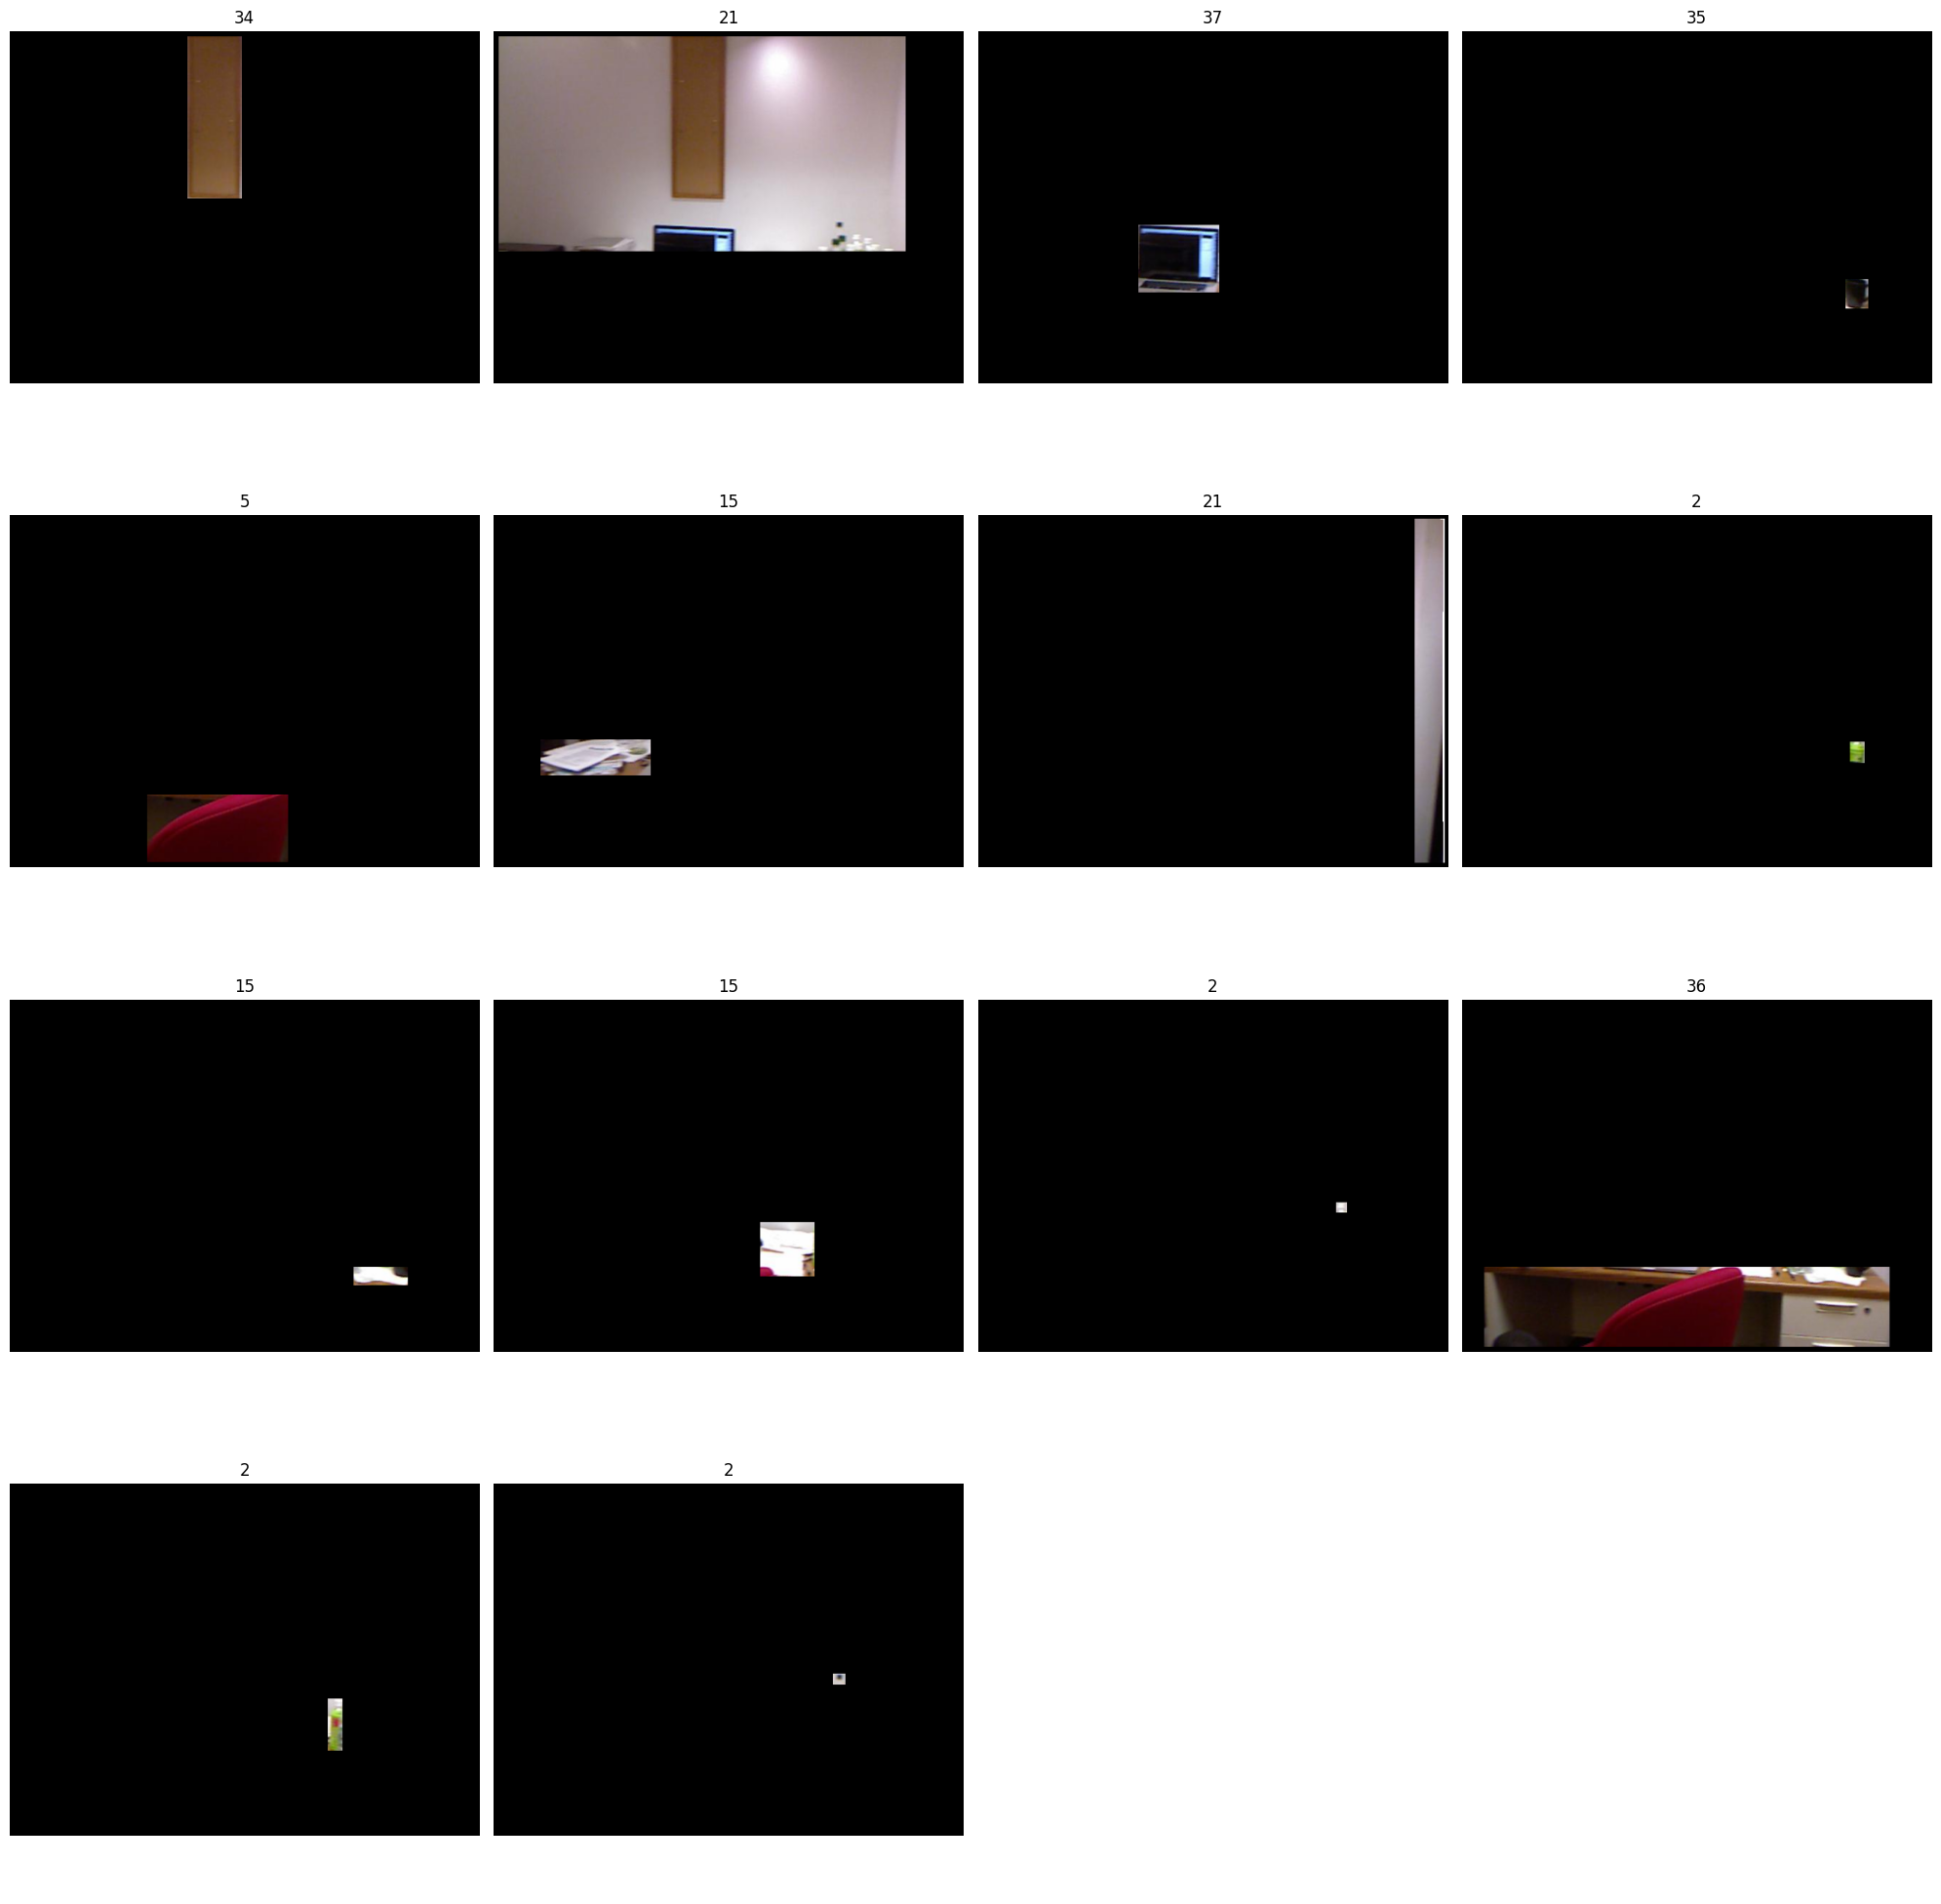

In [21]:
pics_per_row = 4
_, subplts = plt.subplots(int(np.ceil(np.sum(Y_supressed!=0)/pics_per_row)), pics_per_row, figsize=(20, 20))
for subplt in subplts.flatten() :
    subplt.axis('off')
plt.tight_layout()

for idx, ids in enumerate(np.argwhere(Y_supressed != 0).flatten()) :
    x, y, w, h = regions_supressed[ids]
    output = np.zeros_like(image)
    output[y:y+h, x:x+w] = image[y:y+h, x:x+w]
    # print(f"pred class = {Y_supressed[ids]}")
    subplts[idx//pics_per_row][idx%pics_per_row].imshow(output)
    subplts[idx//pics_per_row][idx%pics_per_row].set_title(Y_supressed[ids])
plt.show()

In [22]:
print(f"total time taken: {(time.time() - tic):.2f}s")

total time taken: 35.14s
